In [29]:
import ray
ray.init()

from sklearnex import patch_sklearn
patch_sklearn()

import modin.pandas as pd

In [30]:
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [31]:
df = pd.read_csv("../../dataset/freshwater/dataset.csv", index_col="Index")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956842 entries, 0 to 5956841
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Color                   object 
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Source                  object 
 17  Water Temperature       float64
 18  Air Temperature         float64
 19  Month                   object 
 20  Day                     float64
 21  Time of Day             float64

In [32]:
df_nona = df.drop(columns=["Month", "Day", "Time of Day"])
df_nona["Color"] = df_nona["Color"].astype("category")
df_nona["Source"] = df_nona["Source"].astype("category")

In [33]:
df_cat = pd.get_dummies(data=df_nona, columns=["Color", "Source"])

In [34]:
original_columns = df_cat.columns.tolist()
original_columns.remove("Target")
df_cat = df_cat.reindex(columns=original_columns + ["Target"])

In [35]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956842 entries, 0 to 5956841
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Turbidity               float64
 7   Fluoride                float64
 8   Copper                  float64
 9   Odor                    float64
 10  Sulfate                 float64
 11  Conductivity            float64
 12  Chlorine                float64
 13  Manganese               float64
 14  Total Dissolved Solids  float64
 15  Water Temperature       float64
 16  Air Temperature         float64
 17  Color_Colorless         uint8  
 18  Color_Faint Yellow      uint8  
 19  Color_Light Yellow      uint8  
 20  Color_Near Colorless    uint8  
 21  Color_Yellow            uint8  

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_cat.iloc[:, :-1], df_cat.iloc[:, -1], stratify=df_cat.iloc[:, -1], test_size=.2, random_state=42)

# Datasets creation
xgb_train = xgb.DMatrix(X_train, label=np.array(y_train))
xgb_test = xgb.DMatrix(X_test, label=np.array(y_test))

In [42]:
params = {
    "tree_method": "gpu_hist",
    "gpu_id": 0,
    "objective": 'binary:logistic'
}
bst = xgb.train(params, xgb_train, 100)

In [43]:
preds = bst.predict(xgb_test) > 0.5
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90    830318
           1       0.73      0.89      0.80    361051

    accuracy                           0.87   1191369
   macro avg       0.84      0.87      0.85   1191369
weighted avg       0.88      0.87      0.87   1191369



In [44]:
bst.get_score(importance_type="gain")

{'pH': 1422.4903564453125,
 'Iron': 694.2645874023438,
 'Nitrate': 599.9300537109375,
 'Chloride': 1322.914306640625,
 'Lead': 29.453645706176758,
 'Zinc': 81.87345123291016,
 'Turbidity': 1734.6484375,
 'Fluoride': 601.4773559570312,
 'Copper': 1108.0240478515625,
 'Odor': 1059.975830078125,
 'Sulfate': 250.41537475585938,
 'Conductivity': 9.408175468444824,
 'Chlorine': 687.846923828125,
 'Manganese': 2501.011474609375,
 'Total Dissolved Solids': 482.4469909667969,
 'Water Temperature': 9.62266731262207,
 'Air Temperature': 9.512642860412598,
 'Color_Colorless': 759.9617919921875,
 'Color_Faint Yellow': 109.9887466430664,
 'Color_Light Yellow': 919.8439331054688,
 'Color_Near Colorless': 483.05767822265625,
 'Color_Yellow': 1737.23388671875,
 'Source_Aquifer': 10.684309959411621,
 'Source_Ground': 8.896981239318848,
 'Source_Lake': 9.29026985168457,
 'Source_Reservoir': 7.933280944824219,
 'Source_River': 6.440029621124268,
 'Source_Spring': 9.347721099853516,
 'Source_Stream': 7.728

<AxesSubplot: >

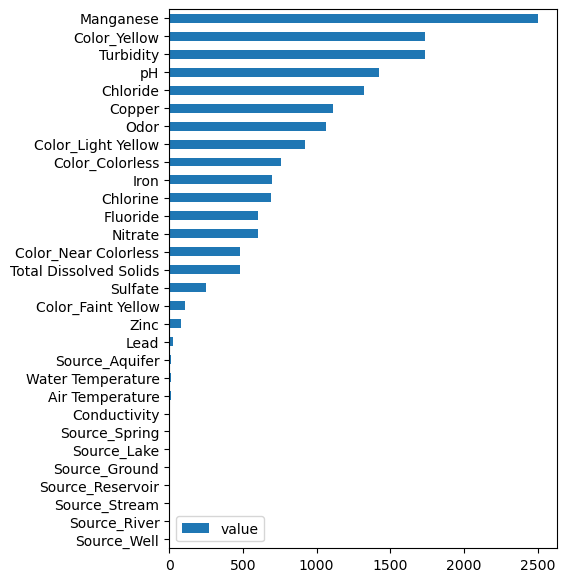

In [45]:
dd = pd.DataFrame.from_dict(bst.get_score(importance_type="gain"), orient="index", columns=["value"])
dd.sort_values("value").plot(kind="barh", figsize=(5, 7))